# 大数据分析
## 第二次作业

__首先导入必要的库__

In [2]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

from scipy import sparse 
from scipy.stats import norm
from numpy import *

import warnings
warnings.filterwarnings("ignore")

# (1)数据预处理
__数据直接通过pandas直接读入__    
__为了方便将数据做成矩阵，这里对用户ID做了一个映射，UID -> {0 - 9999}。同样，对电影的ID也做了映射 MID -> {0 - 9999}__    
__另外为了避免每次启动程序执行该过程，所及将映射完成之后的数据保存本地文件，下次可以直接读入__

In [3]:
#是否读取原始数据
F_netflix_test = 'netflix_test.csv'
F_netflix_train = 'netflix_train.csv'
F_users = 'users.csv'
F_movie_titles = 'movie_titles.csv'
F_users_T = 'users_T.csv'

if os.path.exists(F_netflix_test)==False \
    or os.path.exists(F_netflix_train)==False \
    or os.path.exists(F_users)==False \
    or os.path.exists(F_movie_titles)==False \
    or os.path.exists(F_users_T)==False:
    print '从原始数据读取并处理。'
    #数据读入
    df_file_test = pd.read_csv('netflix_test.txt' , sep=' ' , header = None , names = ['UID','MID','score','date'])
    df_file_train = pd.read_csv('netflix_train.txt' , sep=' ' , header = None , names = ['UID','MID','score','date'])
    df_file_users = pd.read_csv('users.txt' , sep=' ' , header = None , names = ['UID'])

    #电影名字存在有特殊字符，单独写代码进行处理
    df_file_titles = pd.DataFrame(index = [],columns = ['YEAR','MNAME'])
    lines = [line.strip().decode('utf', 'ignore') for line in open('movie_titles.txt').readlines()]
    for line in lines:
        splstr = line.split(',')
        MID = splstr[0]
        YEAR = splstr[1]
        MNAME = line[len(MID)+len(YEAR)+2:]
        df_file_titles.loc[MID,'YEAR'] = YEAR
        df_file_titles.loc[MID,'MNAME'] = MNAME
        
    #用户INDEX与之用户ID的对应表，和df_file_users构成逆表关系，互查
    df_file_users_T = df_file_users[:]
    df_file_users_T = df_file_users_T.reset_index()
    df_file_users_T = df_file_users_T.set_index('UID')
    df_file_users_T.rename(columns = {'index':'UIDX'},inplace=True)
    
    #训练测试数据添加UIDX列保证UIDX取值范围控制再在0~9999之间
    df_file_train_UIDX = df_file_train['UID']
    df_file_test_UIDX = df_file_test['UID']
    for index in df_file_users_T.index.values:
        df_file_train_UIDX = df_file_train_UIDX.replace(index, int(df_file_users_T.loc[index,'UIDX']))
        df_file_test_UIDX = df_file_test_UIDX.replace(index, int(df_file_users_T.loc[index,'UIDX']))
    df_file_train['UIDX'] = df_file_train_UIDX
    df_file_test['UIDX'] = df_file_test_UIDX

    #训练测试数据添加MIDX列保证MIDX取值范围控制再在0~9999之间
    df_file_train['MIDX'] = df_file_train['MID'] - 1
    df_file_test['MIDX'] = df_file_test['MID'] - 1
    
    #保存
    df_file_test.to_csv(F_netflix_test)
    df_file_train.to_csv(F_netflix_train)
    df_file_users.to_csv(F_users)
    df_file_titles.to_csv(F_movie_titles)
    df_file_users_T.to_csv(F_users_T)
    
else:
    print '直接读取已有数据。'
    df_file_test = pd.read_csv(F_netflix_test)
    df_file_train = pd.read_csv(F_netflix_train)
    df_file_users = pd.read_csv(F_users)
    df_file_titles = pd.read_csv(F_movie_titles)
    df_file_users_T = pd.read_csv(F_users_T)
    
print '数据读入完成！'

直接读取已有数据。
数据读入完成！


__完成数据读入后，将数据看作悉数矩阵数据装入（sparse.coo_matrix），然后直接张成一张完整的10000 * 10000的矩阵__    
__训练数据与测试结果数据相同处理方式，这一步得到矩阵X_train和X_test__

In [4]:
#创建训练和测试矩阵
row = df_file_train['UIDX'].values
col = df_file_train['MIDX'].values
data= df_file_train['score'].values
X_train = sparse.coo_matrix((data, (row, col)), shape=(10000, 10000)).toarray()
X_train = mat(X_train)

row = df_file_test['UIDX'].values
col = df_file_test['MIDX'].values
data= df_file_test['score'].values
X_test = sparse.coo_matrix((data, (row, col)), shape=(10000, 10000)).toarray()
X_test = mat(X_test)

__接下来生成训练矩阵和测试矩阵的标记矩阵__     
__另外本题采用均方根误差(Root Mean Square Error)作为推荐结果优劣的评价标准，在此定义了RMSE数值计算函数__   
_RMSE定义函数：_    
$$RMSE = \sqrt{\frac{1}{n}(\sum_{<i,j>\in Test}(X_{ij}-\hat X_{ij})^2)}$$
     
_实际矩阵运算函数算法：_    
$$N = (X \cdot \hat X_{sign} - \hat X)\cdot(X \cdot \hat X_{sign} - \hat X)$$
$$RMSE = \sqrt{\frac{\sum N}{\sum\hat X}}$$
_详见如下代码_

In [4]:
#求两个矩阵的标记矩阵
bool_train = np.sign(X_train)
bool_test = np.sign(X_test)

def get_RMSE(pre_train):
    pre_test = multiply(pre_train,bool_test)
    sub_2 = np.square(pre_test - X_test)
    RMSE = np.sqrt( sub_2.sum() / bool_test.sum() )
    return RMSE

__下面通过基于user的协同过滤的算法进行推荐，对于未知数据位置采取基于相似度加权的均值计算方案。__     
_首先，相似度函数采用向量余弦算法：_
$$sim(X_i,X_k) = cos(X_i,X_k) = \frac{X_i\cdot X_k}{\left|X_i\right| \cdot \left|X_k\right|}$$
_ i 用户对 j 电影打分算法：_
$$score(i,j)=\frac{\sum_k sim(X_i,X_k) \cdot score(k,j)}{\sum_k sim(X_i,X_k)}$$

In [7]:
all_begin = datetime.datetime.now()
#求各个列的模
mod_train = np.sqrt (multiply(X_train,X_train) * mat(np.ones((X_train.shape[0],1))))
#逐行单位化之后的向量
unit_train = np.nan_to_num(divide(X_train,mod_train))
#得到用户间cos关系矩阵
cos_train = unit_train * unit_train.T

#计算出所有预测结果
pre_train = np.nan_to_num(divide(cos_train * X_train,cos_train * bool_train))

#计算RMSE
RMSE = get_RMSE(pre_train)

all_end = datetime.datetime.now()
print 'RMSE= ' + str(RMSE)
print 'Time= ' + str(all_end - all_begin)

RMSE= 1.01910719672
Time= 0:02:16.162281


In [5]:
#Frobenius范数
def Frobenius(matrix):
    diag = np.diag(matrix)
    diag = diag * diag
    return diag.sum()

#计算J值
def get_J( U , V , ld ):
    sub = multiply( bool_train , subtract( X_train , U * V.T ) )
    step1 = np.square(Frobenius(sub)) / 2
    step2 = np.square(Frobenius(U)) * ld
    step3 = np.square(Frobenius(V)) * ld
    return step1 + step2 + step3

#求偏导数
def get_pd_U( U , V , ld ):
    return multiply( bool_train , U * V.T - X_train ) * V + 2 * ld * U

def get_pd_V( U , V , ld ):
    return multiply( bool_train , U * V.T - X_train ).T * U + 2 * ld * V

#步进后的矩阵
def get_next_U( U , V , ld , af ):
    return U - ( af * get_pd_U( U , V , ld ) )

def get_next_V( U , V , ld , af ):
    return V - ( af * get_pd_V( U , V , ld ) )

#梯度下降算法
def Gradient_Decline( k , af , ld , maxCycles ):
    #按照正态分布，随机生成U、V
    m = X_train.shape[0]
    n = X_train.shape[1]
    U = mat(np.random.normal(size=m*k)).reshape(m,k)
    V = mat(np.random.normal(size=n*k)).reshape(n,k)
    
    #记录返回结果的list
    l_idx = []
    l_J = []
    l_RMSE = []
    #最多循环次数
    for cyc in  range(maxCycles):
        U = get_next_U( U , V , ld , af )
        V = get_next_V( U , V , ld , af )
        J = get_J( U , V , ld )
        RMSE = get_RMSE(U*V.T)
        l_idx.append(cyc)
        l_J.append(J)
        l_RMSE.append(RMSE)
        #print cyc , J , RMSE
    
    return l_idx , l_J , l_RMSE

In [6]:
mcol = 'bcgkmry'
def show_Gradient_Decline_plot( maxrun , af , samerand ):
    report = pd.DataFrame([],columns=['k','lamda','min RMSE','min J','min RMSE idx','time'])
    
    plt.figure(figsize=(14,10))
    cidx = 0
    for k in (20,50):
        for ld in (0.1,0.01,0.001):
            #不同参数下计算梯度下降算法
            if samerand != 0:
                np.random.seed(k*samerand)
            tbegin = datetime.datetime.now()
            l_idx , l_J , l_RMSE = Gradient_Decline( k , af , ld ,maxrun )
            tend = datetime.datetime.now()

            report.loc['('+str(k)+','+str(ld)+')','k'] = k
            report.loc['('+str(k)+','+str(ld)+')','lamda'] = ld
            report.loc['('+str(k)+','+str(ld)+')','min RMSE'] = min(l_RMSE)
            report.loc['('+str(k)+','+str(ld)+')','min J'] = min(l_J)
            report.loc['('+str(k)+','+str(ld)+')','min RMSE idx'] = l_RMSE.index(min(l_RMSE))
            report.loc['('+str(k)+','+str(ld)+')','time'] = str(tend - tbegin)
            #可视化显示一下结果
            plt.plot( l_idx , l_RMSE , mcol[cidx]+'-' , linewidth = 2 , label='( '+ str(k) + ' , ' + str(ld) +' )' )
            plt.plot( (min(l_idx),max(l_idx)) , (min(l_RMSE),min(l_RMSE)) , mcol[cidx]+'--' , linewidth = 2 )
            plt.plot( l_RMSE.index(min(l_RMSE)) , min(l_RMSE) , mcol[cidx]+'*' , linewidth = 2 )
            plt.plot( (l_RMSE.index(min(l_RMSE)),l_RMSE.index(min(l_RMSE))) , (min(l_RMSE)-0.2,min(l_RMSE)+0.2) , mcol[cidx]+'--' , linewidth = 1 )
            cidx += 1

    plt.title('RMSE for k and lamda')
    plt.grid( True )
    plt.legend()
    plt.show()

    return report

------------------------相同 k 使用 相同 UV  A1组  ------------------------


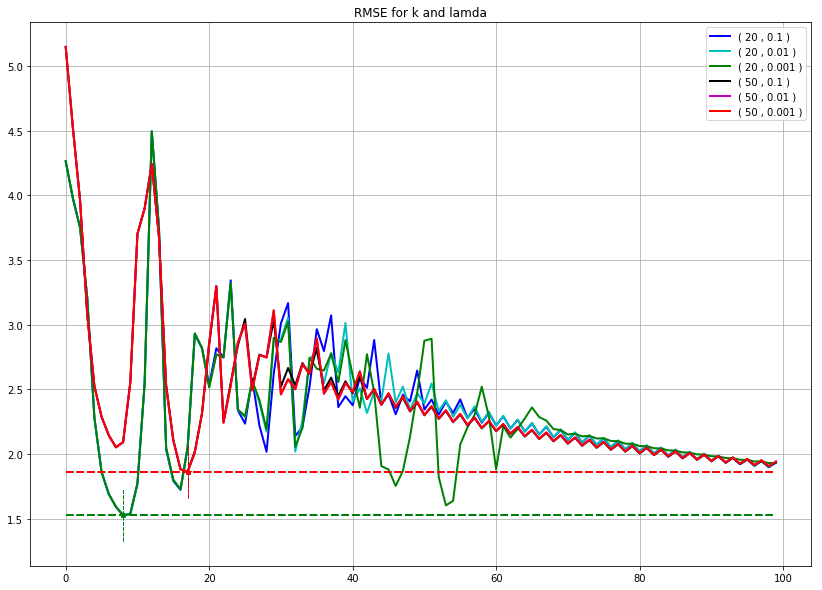

             k  lamda min RMSE        min J min RMSE idx            time
(20,0.1)    20    0.1  1.52753  1.24614e+06            8  0:08:03.887272
(20,0.01)   20   0.01  1.52781  1.23306e+06            8  0:08:04.015809
(20,0.001)  20  0.001  1.52784       764810            8  0:08:02.163411
(50,0.1)    50    0.1  1.86489       961164           17  0:09:13.013274
(50,0.01)   50   0.01  1.86368       970428           17  0:10:21.054211
(50,0.001)  50  0.001  1.86355       971209           17  0:10:21.135803


In [7]:
print '------------------------相同 k 使用 相同 UV  A1组  ------------------------'
print show_Gradient_Decline_plot( 100 , 0.0002 , 1111 )

------------------------相同 k 使用 相同 UV  A2组  ------------------------


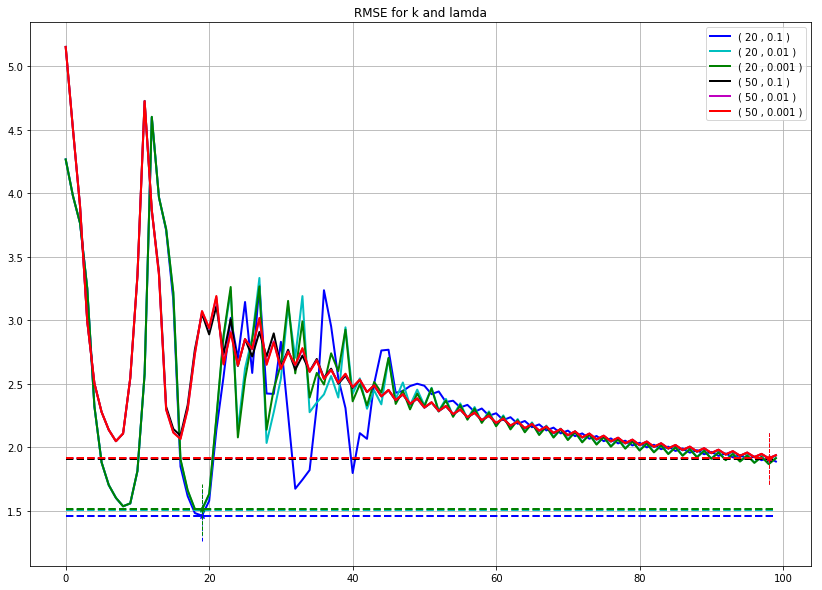

             k  lamda min RMSE   min J min RMSE idx            time
(20,0.1)    20    0.1  1.46321  812084           19  0:08:34.281617
(20,0.01)   20   0.01  1.50728  837453           19  0:08:02.798584
(20,0.001)  20  0.001  1.51211  841388           19  0:08:11.375312
(50,0.1)    50    0.1   1.9124  992844           98  0:08:45.605132
(50,0.01)   50   0.01  1.91455  994265           98  0:08:44.596228
(50,0.001)  50  0.001  1.91478  994457           98  0:09:08.341387


In [10]:
print '------------------------相同 k 使用 相同 UV  A2组  ------------------------'
print show_Gradient_Decline_plot( 100 , 0.0002 , 222 )

------------------------相同 k 使用 相同 UV  A3组  ------------------------


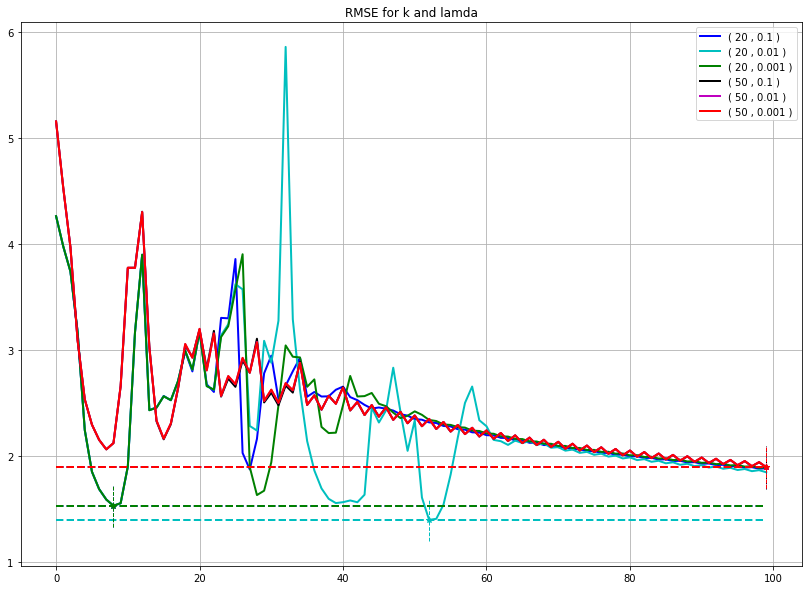

             k  lamda min RMSE        min J min RMSE idx            time
(20,0.1)    20    0.1  1.52768  1.02147e+06            8  0:09:38.370356
(20,0.01)   20   0.01   1.3944       549352           52  0:09:36.951122
(20,0.001)  20  0.001  1.52798       916490            8  0:09:37.991321
(50,0.1)    50    0.1  1.89042       983927           99  0:10:23.937886
(50,0.01)   50   0.01  1.89194       984628           99  0:10:26.254560
(50,0.001)  50  0.001   1.8921       984702           99  0:10:27.108712


In [8]:
print '------------------------相同 k 使用 相同 UV  A3组  ------------------------'
print show_Gradient_Decline_plot( 100 , 0.0002 , 333 )

------------------------完全随机 UV  B1组  ------------------------


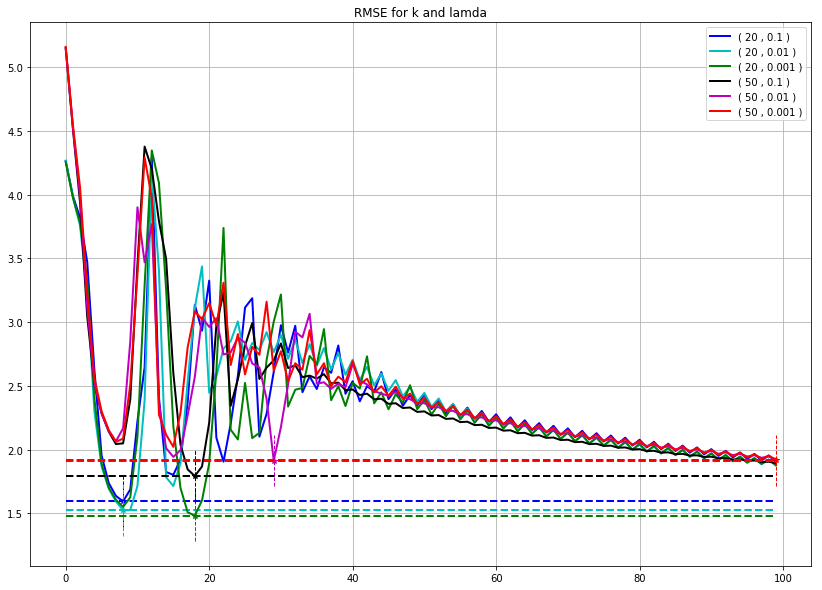

             k  lamda min RMSE        min J min RMSE idx            time
(20,0.1)    20    0.1  1.59443  1.12951e+06            8  0:08:34.260078
(20,0.01)   20   0.01  1.52556  1.09791e+06            8  0:08:07.282832
(20,0.001)  20  0.001  1.48337       808830           18  0:07:57.045116
(50,0.1)    50    0.1   1.7937       863573           18  0:09:42.289560
(50,0.01)   50   0.01  1.91229  1.27784e+06           29  0:08:33.378887
(50,0.001)  50  0.001  1.91684  1.19581e+06           99  0:08:55.554556


In [7]:
print '------------------------完全随机 UV  B1组  ------------------------'
print show_Gradient_Decline_plot( 100 , 0.0002 , 0 )

------------------------完全随机 UV  B2组  ------------------------


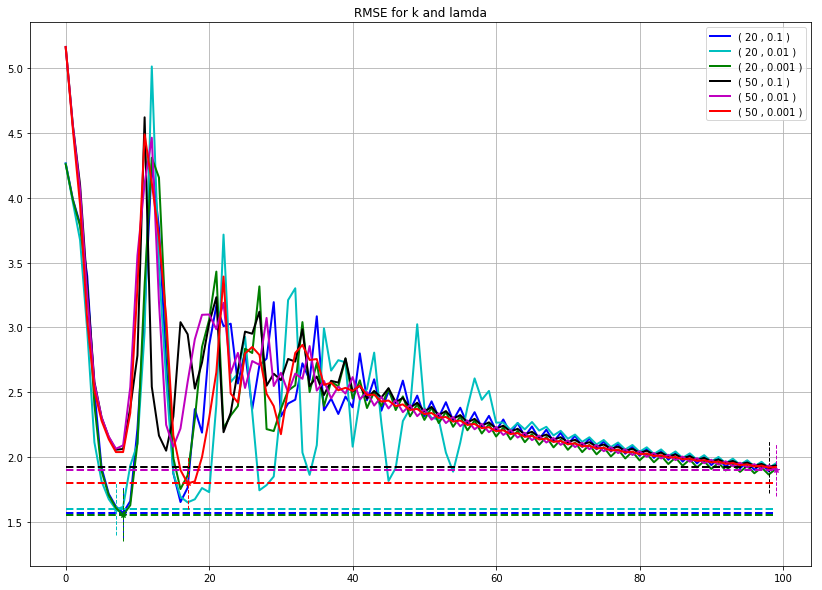

             k  lamda min RMSE        min J min RMSE idx            time
(20,0.1)    20    0.1  1.57213  1.16903e+06            8  0:09:46.026884
(20,0.01)   20   0.01  1.59856  1.21486e+06            7  0:09:45.233659
(20,0.001)  20  0.001  1.55457  1.10327e+06            8  0:09:45.880000
(50,0.1)    50    0.1  1.92598       842635           98  0:10:31.060942
(50,0.01)   50   0.01  1.90333       883314           99  0:10:31.929634
(50,0.001)  50  0.001  1.79857       958142           17  0:10:31.747283


In [9]:
print '------------------------完全随机 UV  B2组  ------------------------'
print show_Gradient_Decline_plot( 100 , 0.0002 , 0 )

------------------------完全随机 UV  B3组  ------------------------


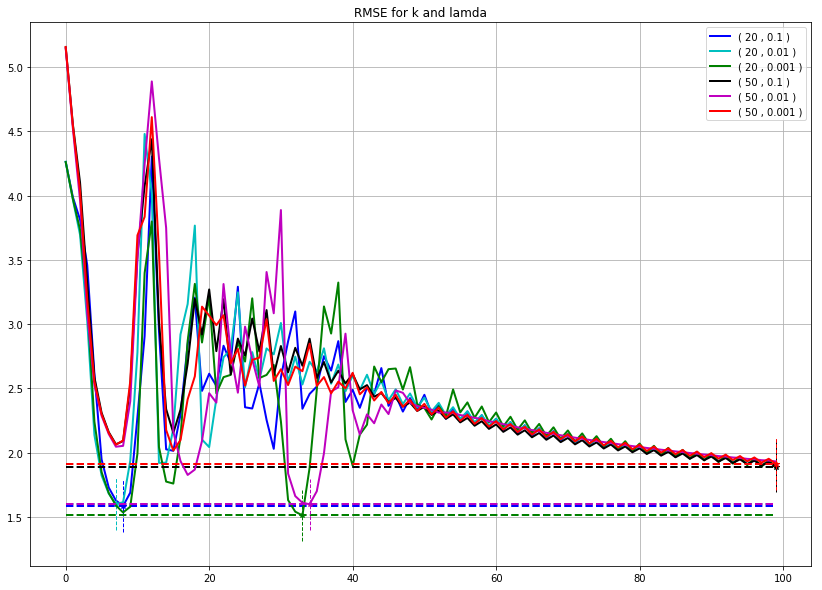

             k  lamda min RMSE        min J min RMSE idx            time
(20,0.1)    20    0.1  1.58405  1.31355e+06            8  0:09:46.075638
(20,0.01)   20   0.01  1.59869  1.18448e+06            7  0:09:45.768738
(20,0.001)  20  0.001  1.51094       790170           33  0:09:47.837524
(50,0.1)    50    0.1  1.89052       980153           99  0:10:32.444060
(50,0.01)   50   0.01  1.59776       890805           34  0:10:31.422287
(50,0.001)  50  0.001  1.91204       975134           99  0:10:31.239639


In [10]:
print '------------------------完全随机 UV  B3组  ------------------------'
print show_Gradient_Decline_plot( 100 , 0.0002 , 0 )

------------------------相同 k 使用 相同 UV  A4组  ------------------------


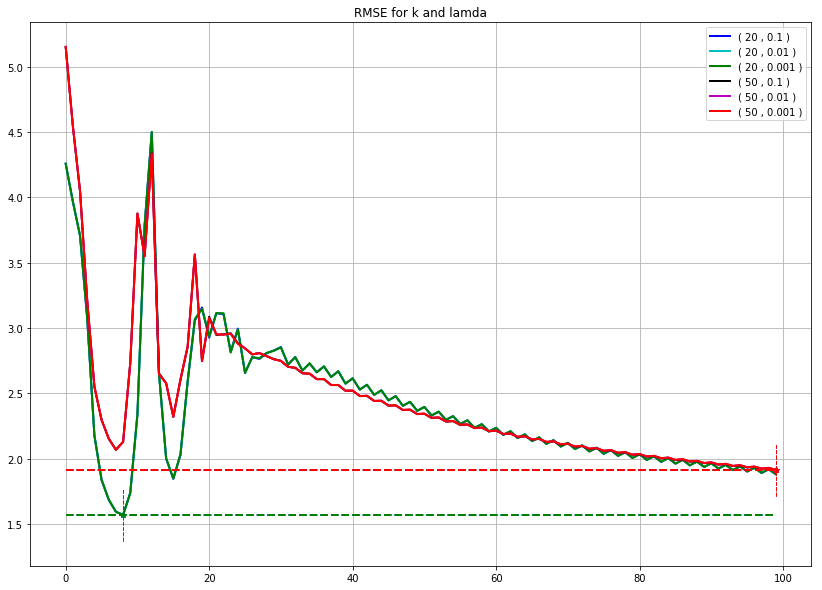

             k  lamda min RMSE        min J min RMSE idx            time
(20,0.1)    20    0.1  1.57001  1.19389e+06            8  0:08:10.080265
(20,0.01)   20   0.01  1.57032  1.19466e+06            8  0:08:03.931063
(20,0.001)  20  0.001  1.57036  1.19473e+06            8  0:08:56.688077
(50,0.1)    50    0.1  1.91365       889868           99  0:10:27.142583
(50,0.01)   50   0.01  1.91537       890386           99  0:10:30.613715
(50,0.001)  50  0.001  1.91554       890442           99  0:10:32.943280


In [11]:
print '------------------------相同 k 使用 相同 UV  A4组  ------------------------'
print show_Gradient_Decline_plot( 100 , 0.0002 , 4444 )

------------------------相同 k 使用 相同 UV  A5组  ------------------------


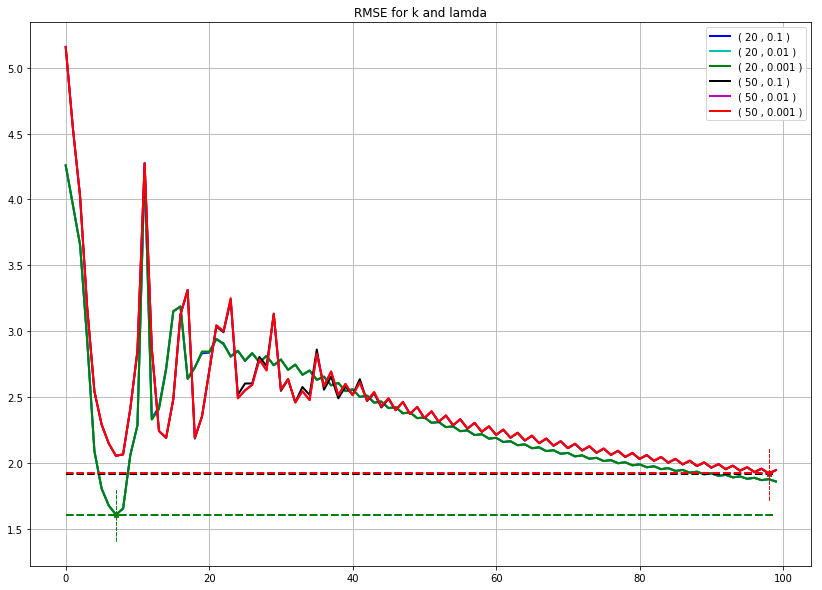

             k  lamda min RMSE        min J min RMSE idx            time
(20,0.1)    20    0.1  1.60855  1.14203e+06            7  0:09:51.205540
(20,0.01)   20   0.01  1.60883  1.14347e+06            7  0:09:50.995388
(20,0.001)  20  0.001  1.60885  1.14362e+06            7  0:09:50.835994
(50,0.1)    50    0.1  1.92052       825553           98  0:10:33.708716
(50,0.01)   50   0.01   1.9227       831381           98  0:10:34.857882
(50,0.001)  50  0.001  1.92291       831991           98  0:10:34.858096


In [12]:
print '------------------------相同 k 使用 相同 UV  A5组  ------------------------'
print show_Gradient_Decline_plot( 100 , 0.0002 , 5555 )

------------------------完全随机 UV  B4组  ------------------------


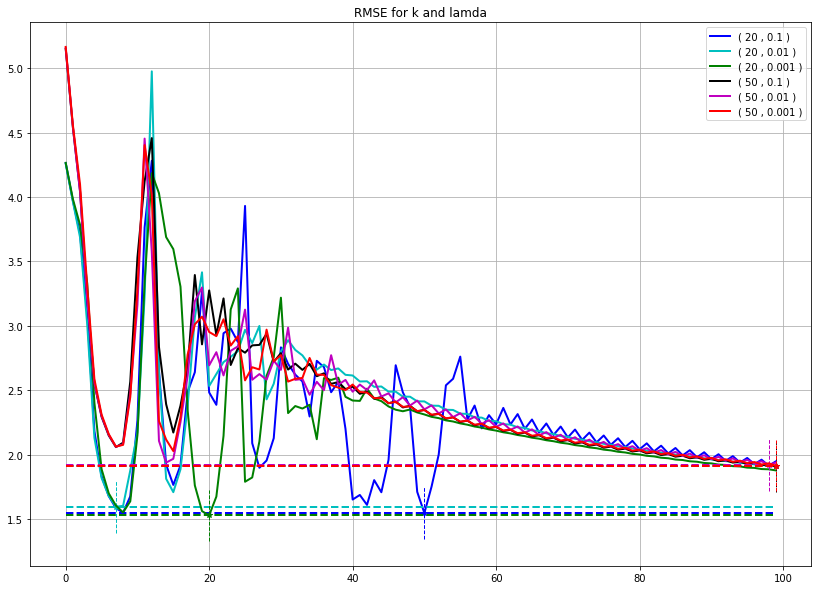

             k  lamda min RMSE        min J min RMSE idx            time
(20,0.1)    20    0.1  1.54597       688120           50  0:09:52.493949
(20,0.01)   20   0.01  1.59496       968323            7  0:09:51.471424
(20,0.001)  20  0.001  1.52854       916977           20  0:09:51.032467
(50,0.1)    50    0.1    1.908  1.06188e+06           99  0:10:34.891253
(50,0.01)   50   0.01  1.92075       947756           98  0:10:29.828482
(50,0.001)  50  0.001  1.91363       940538           99  0:10:28.480744


In [13]:
print '------------------------完全随机 UV  B4组  ------------------------'
print show_Gradient_Decline_plot( 100 , 0.0002 , 0 )

------------------------完全随机 UV  B5组  ------------------------


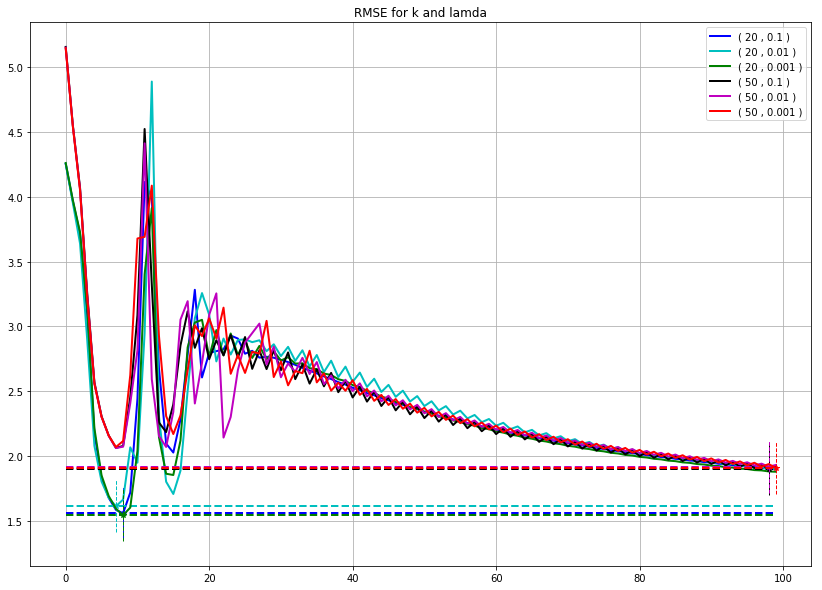

             k  lamda min RMSE        min J min RMSE idx            time
(20,0.1)    20    0.1  1.55565  1.21524e+06            8  0:09:45.432308
(20,0.01)   20   0.01  1.60978       974343            7  0:09:40.594180
(20,0.001)  20  0.001  1.54119  1.13752e+06            8  0:09:41.169767
(50,0.1)    50    0.1  1.89616       831024           98  0:10:26.234435
(50,0.01)   50   0.01  1.91577       767292           98  0:10:25.738832
(50,0.001)  50  0.001   1.9063       860070           99  0:10:26.305297


In [14]:
print '------------------------完全随机 UV  B5组  ------------------------'
print show_Gradient_Decline_plot( 100 , 0.0002 , 0 )